RFM 클러스터링 분석 시작! (쿠폰 특성 포함)
데이터 로딩 완료:
  transaction: 2,595,732건
  demographic: 801건
  coupon_redempt: 2,318건
  campaign_table: 7,208건
=== 기본 데이터 결합 ===
결합된 데이터: 2,595,732건
인구통계 커버리지: 1,427,303명 (55.0%)
=== 기본 RFM 계산 ===
분석 기준일: DAY 711
기본 RFM 생성: 2500명

RFM 기본 통계:
           Recency    Frequency      Monetary
count  2500.000000  2500.000000   2500.000000
mean     25.574000   110.593600   3222.985232
std      62.790655   115.669368   3349.026076
min       0.000000     1.000000      8.170000
25%       1.000000    39.000000    970.740000
50%       6.000000    79.000000   2157.750000
75%      20.000000   142.250000   4413.320000
max     657.000000  1300.000000  38319.790000
=== 쿠폰 사용 특성 추가 ===
쿠폰 사용 고객: 434명
캠페인 수령 고객: 1584명
확장된 RFM: 2500명
=== 쿠폰 효과성 지표 계산 ===
쿠폰 사용 현황:
  쿠폰 사용자: 434명 (17.4%)
  캠페인 수령자: 1,584명 (63.4%)
  평균 쿠폰 효율성: 0.132
=== 기본 RFM 클러스터링 ===
기본 RFM 클러스터 분포:
  Cluster 0: 689명 (27.6%)
  Cluster 1: 608명 (24.3%)
  Cluster 2: 642명 (25.7%)
  Cluster 3: 561명 (22.4%)
=== 쿠폰 특성 포함 

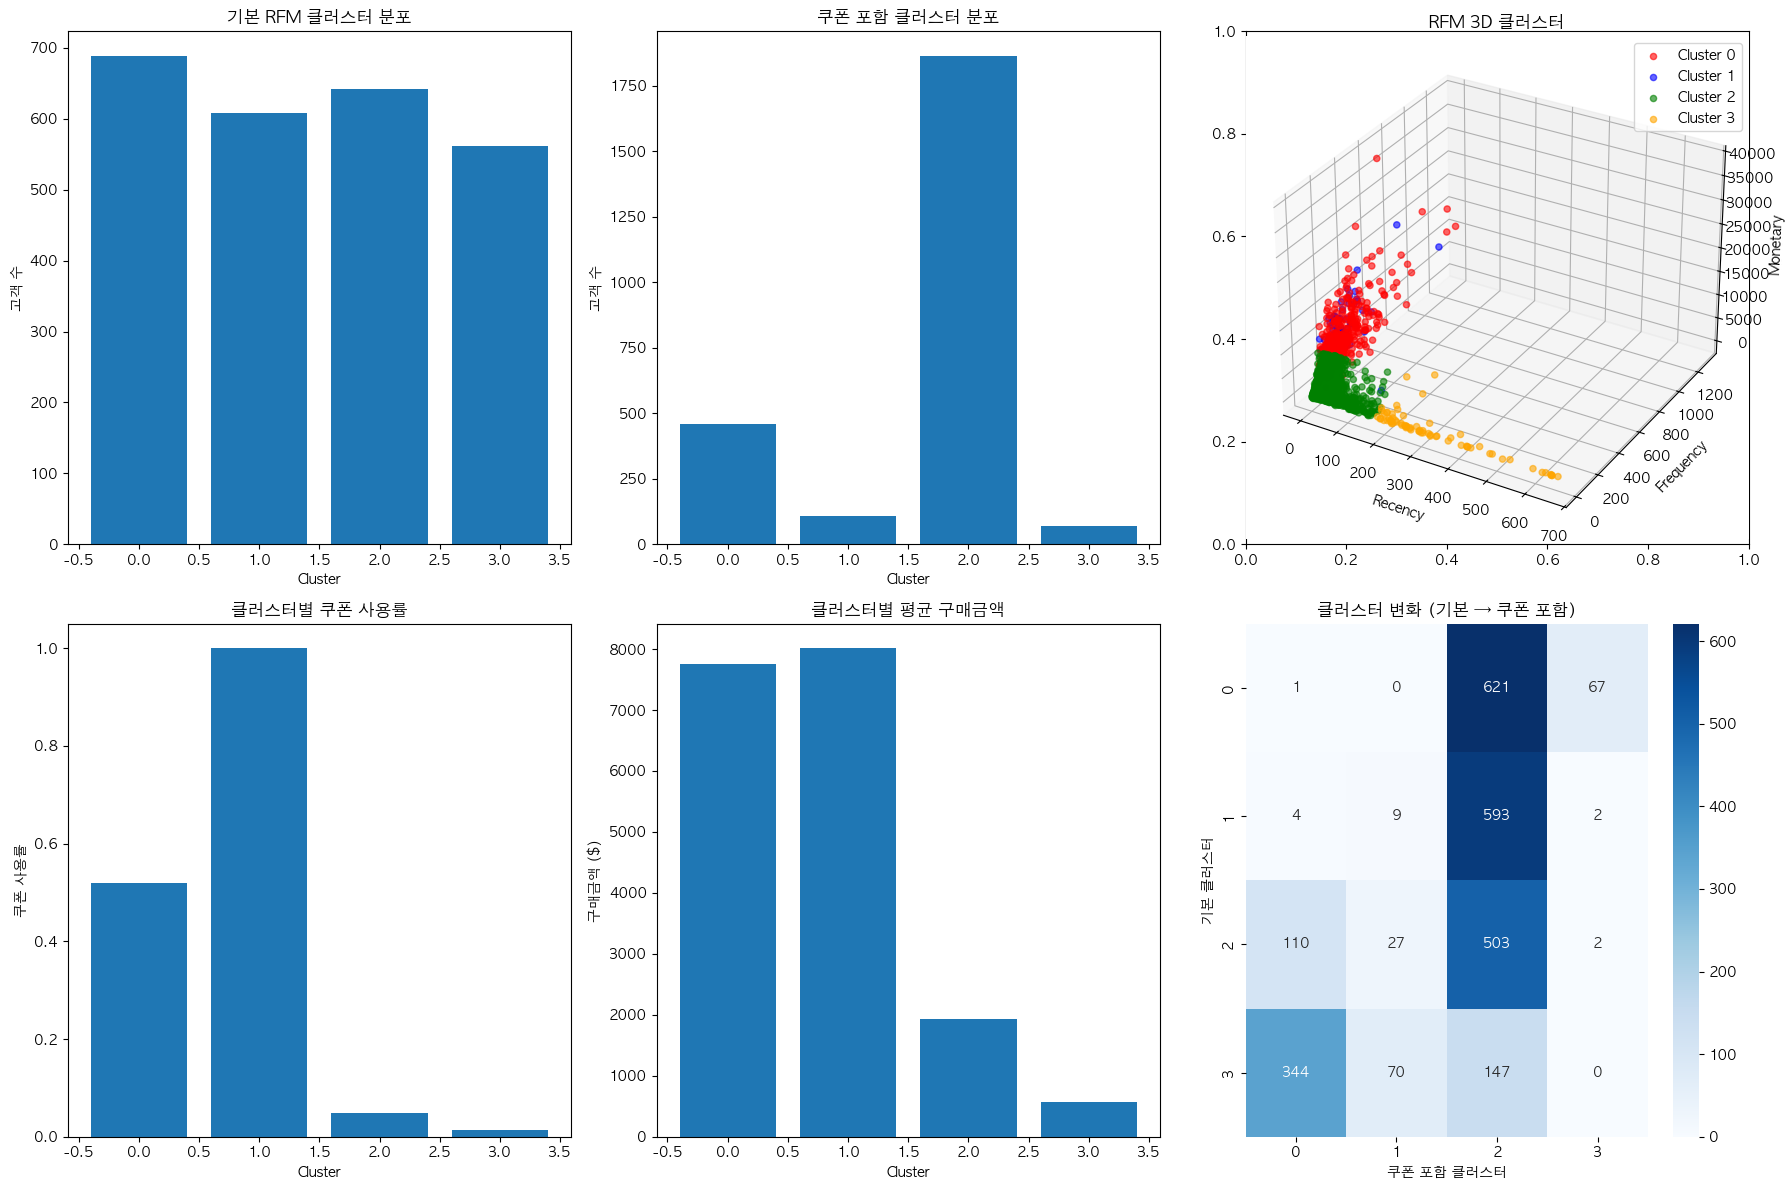


RFM 클러스터링 결과 저장:
  rfm_clusters.csv: 2500명, 25개 특성
=== RFM 클러스터링 분석 완료 ===
쿠폰 특성을 포함한 고객 세분화 완성!
다음 단계: 클러스터별 마케팅 전략 수립


In [1]:
# %%
# RFM 클러스터링 분석 - 쿠폰 데이터 포함
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

print("RFM 클러스터링 분석 시작! (쿠폰 특성 포함)")

# %%
# 1. 기본 데이터 로딩

raw_path = '../data/raw/'
processed_path = '../data/processed/'

# 기본 데이터 로딩
df_demo = pd.read_csv(f'{raw_path}hh_demographic.csv')
df_tran = pd.read_csv(f'{raw_path}transaction_data.csv')
df_prod = pd.read_csv(f'{raw_path}product.csv')

# 쿠폰 관련 데이터
coupon_redempt = pd.read_csv(f'{raw_path}coupon_redempt.csv')
campaign_table = pd.read_csv(f'{raw_path}campaign_table.csv')
campaign_desc = pd.read_csv(f'{raw_path}campaign_desc.csv')

print(f"데이터 로딩 완료:")
print(f"  transaction: {len(df_tran):,}건")
print(f"  demographic: {len(df_demo):,}건") 
print(f"  coupon_redempt: {len(coupon_redempt):,}건")
print(f"  campaign_table: {len(campaign_table):,}건")

# %%
# 2. 기본 데이터 결합

print("=== 기본 데이터 결합 ===")

# 거래 + 인구통계 + 상품정보 결합
df = pd.merge(df_tran, df_demo, on='household_key', how='left')
df = pd.merge(df, df_prod, on='PRODUCT_ID', how='left')

print(f"결합된 데이터: {len(df):,}건")
print(f"인구통계 커버리지: {df['AGE_DESC'].notna().sum():,}명 ({df['AGE_DESC'].notna().sum()/len(df)*100:.1f}%)")

# %%
# 3. 기본 RFM 계산

print("=== 기본 RFM 계산 ===")

# 구매 날짜의 최대값 (최근 날짜)
max_day = df['DAY'].max()
print(f"분석 기준일: DAY {max_day}")

# RFM 지표 생성
rfm_basic = df.groupby('household_key').agg(
    Recency=('DAY', lambda x: max_day - x.max()),      # 최근 구매로부터 며칠 지남
    Frequency=('BASKET_ID', 'nunique'),                # 구매 바스켓(장바구니) 수
    Monetary=('SALES_VALUE', 'sum')                    # 총 구매금액
).reset_index()

# 인구통계 정보 추가
rfm_basic = pd.merge(rfm_basic, df_demo, on='household_key', how='left')

print(f"기본 RFM 생성: {len(rfm_basic)}명")
print("\nRFM 기본 통계:")
print(rfm_basic[['Recency', 'Frequency', 'Monetary']].describe())

# %%
# 4. 쿠폰 사용 특성 추가

print("=== 쿠폰 사용 특성 추가 ===")

# 4-1. 쿠폰 사용 특성 집계
coupon_features = coupon_redempt.groupby('household_key').agg({
    'COUPON_UPC': 'count',           # 쿠폰 사용 횟수
    'DAY': 'nunique',                # 쿠폰 사용 일수  
    'CAMPAIGN': 'nunique'            # 참여 캠페인 수
}).rename(columns={
    'COUPON_UPC': 'coupon_usage_count',
    'DAY': 'coupon_usage_days',
    'CAMPAIGN': 'campaigns_participated'
})

print(f"쿠폰 사용 고객: {len(coupon_features)}명")

# 4-2. 캠페인 수령 특성
campaign_features = campaign_table.groupby('household_key').agg({
    'CAMPAIGN': 'nunique',           # 수령 캠페인 수
    'DESCRIPTION': 'count'           # 총 수령 건수
}).rename(columns={
    'CAMPAIGN': 'campaigns_received',
    'DESCRIPTION': 'total_campaigns_received'
})

print(f"캠페인 수령 고객: {len(campaign_features)}명")

# 4-3. 기본 RFM에 쿠폰 특성 결합
rfm_enhanced = rfm_basic.copy()
rfm_enhanced = rfm_enhanced.merge(coupon_features, on='household_key', how='left')
rfm_enhanced = rfm_enhanced.merge(campaign_features, on='household_key', how='left')

# 결측치 0으로 처리 (쿠폰/캠페인 참여하지 않은 고객)
coupon_cols = ['coupon_usage_count', 'coupon_usage_days', 'campaigns_participated', 
               'campaigns_received', 'total_campaigns_received']
rfm_enhanced[coupon_cols] = rfm_enhanced[coupon_cols].fillna(0)

print(f"확장된 RFM: {len(rfm_enhanced)}명")

# %%
# 5. 쿠폰 효과성 지표 계산

print("=== 쿠폰 효과성 지표 계산 ===")

# 쿠폰 사용 효율성
rfm_enhanced['coupon_efficiency'] = rfm_enhanced['coupon_usage_count'] / (rfm_enhanced['campaigns_received'] + 1)
rfm_enhanced['coupon_user'] = (rfm_enhanced['coupon_usage_count'] > 0).astype(int)
rfm_enhanced['campaign_receiver'] = (rfm_enhanced['campaigns_received'] > 0).astype(int)

# 쿠폰 관련 통계
print("쿠폰 사용 현황:")
print(f"  쿠폰 사용자: {rfm_enhanced['coupon_user'].sum():,}명 ({rfm_enhanced['coupon_user'].mean()*100:.1f}%)")
print(f"  캠페인 수령자: {rfm_enhanced['campaign_receiver'].sum():,}명 ({rfm_enhanced['campaign_receiver'].mean()*100:.1f}%)")
print(f"  평균 쿠폰 효율성: {rfm_enhanced['coupon_efficiency'].mean():.3f}")

# %%
# 6. 기본 RFM 클러스터링 (기존 방식)

print("=== 기본 RFM 클러스터링 ===")

# RFM 점수 계산 (5분위)
def calculate_rfm_scores(df):
    df = df.copy()
    df['R_score'] = pd.qcut(df['Recency'], 5, labels=[5,4,3,2,1], duplicates='drop')  # 낮을수록 좋음
    df['F_score'] = pd.qcut(df['Frequency'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
    df['M_score'] = pd.qcut(df['Monetary'].rank(method='first'), 5, labels=[1,2,3,4,5], duplicates='drop')
    return df

rfm_enhanced = calculate_rfm_scores(rfm_enhanced)

# 기본 RFM 기반 클러스터링
def create_basic_clusters(df):
    df = df.copy()
    df['RFM_score'] = df['R_score'].astype(int) + df['F_score'].astype(int) + df['M_score'].astype(int)
    
    # RFM 점수 기준 클러스터 분류
    df['basic_cluster'] = pd.cut(df['RFM_score'], 
                                bins=[0, 6, 9, 12, 15], 
                                labels=[0, 1, 2, 3])
    return df

rfm_enhanced = create_basic_clusters(rfm_enhanced)

# 기본 클러스터 분포
basic_cluster_summary = rfm_enhanced['basic_cluster'].value_counts().sort_index()
print("기본 RFM 클러스터 분포:")
for cluster, count in basic_cluster_summary.items():
    ratio = count / len(rfm_enhanced) * 100
    print(f"  Cluster {cluster}: {count:,}명 ({ratio:.1f}%)")

# %%
# 7. 쿠폰 특성 포함 클러스터링

print("=== 쿠폰 특성 포함 클러스터링 ===")

# 클러스터링용 특성 선택
cluster_features = ['Recency', 'Frequency', 'Monetary', 
                   'coupon_usage_count', 'campaigns_participated', 'coupon_efficiency']

# 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(rfm_enhanced[cluster_features])

# K-means 클러스터링 (5개 클러스터)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
rfm_enhanced['enhanced_cluster'] = kmeans.fit_predict(X_scaled)

# 쿠폰 포함 클러스터 분포
enhanced_cluster_summary = rfm_enhanced['enhanced_cluster'].value_counts().sort_index()
print("쿠폰 포함 클러스터 분포:")
for cluster, count in enhanced_cluster_summary.items():
    ratio = count / len(rfm_enhanced) * 100
    print(f"  Cluster {cluster}: {count:,}명 ({ratio:.1f}%)")

# %%
# 8. 클러스터별 특성 비교

print("=== 클러스터별 특성 비교 ===")

# 기본 클러스터 특성
basic_profile = rfm_enhanced.groupby('basic_cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': 'mean',
    'coupon_usage_count': 'mean',
    'campaigns_participated': 'mean',
    'coupon_efficiency': 'mean'
}).round(1)

print("기본 RFM 클러스터별 특성:")
print(basic_profile)

# 쿠폰 포함 클러스터 특성
enhanced_profile = rfm_enhanced.groupby('enhanced_cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean', 
    'coupon_usage_count': 'mean',
    'campaigns_participated': 'mean',
    'coupon_efficiency': 'mean'
}).round(1)

print("\n쿠폰 포함 클러스터별 특성:")
print(enhanced_profile)

# %%
# 9. 클러스터 해석 및 네이밍

print("=== 클러스터 해석 및 네이밍 ===")

def interpret_clusters(profile_df, cluster_type):
    print(f"\n{cluster_type} 클러스터 해석:")
    
    cluster_names = {}
    for idx, row in profile_df.iterrows():
        recency = row['Recency']
        frequency = row['Frequency'] 
        monetary = row['Monetary']
        coupon_usage = row['coupon_usage_count']
        
        # 클러스터 특성 기반 네이밍
        if monetary > profile_df['Monetary'].quantile(0.75):
            if frequency > profile_df['Frequency'].quantile(0.75):
                name = "VIP 고객"
                desc = "매우 최근, 매우 자주, 매우 많이 구매"
            else:
                name = "고가치 고객"  
                desc = "높은 구매금액, 중간 빈도"
        elif frequency > profile_df['Frequency'].quantile(0.75):
            name = "충성 고객"
            desc = "자주 구매하지만 중간 구매금액"
        elif recency > profile_df['Recency'].quantile(0.75):
            name = "이탈 위험 고객"
            desc = "오랫동안 구매하지 않음"
        else:
            name = "일반 고객"
            desc = "보통 수준의 구매 패턴"
            
        # 쿠폰 특성 추가
        if coupon_usage > 0:
            coupon_desc = f", 쿠폰 활용 {coupon_usage:.1f}회"
        else:
            coupon_desc = ", 쿠폰 미사용"
            
        cluster_names[idx] = name
        print(f"  Cluster {idx} ({name}): {desc}{coupon_desc}")
        print(f"    R={recency:.1f}, F={frequency:.1f}, M=${monetary:.0f}")
        
    return cluster_names

basic_names = interpret_clusters(basic_profile, "기본 RFM")
enhanced_names = interpret_clusters(enhanced_profile, "쿠폰 포함")

# %%
# 10. 시각화

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 10-1. 기본 클러스터 분포
basic_counts = rfm_enhanced['basic_cluster'].value_counts().sort_index()
axes[0,0].bar(range(len(basic_counts)), basic_counts.values)
axes[0,0].set_title('기본 RFM 클러스터 분포')
axes[0,0].set_xlabel('Cluster')
axes[0,0].set_ylabel('고객 수')

# 10-2. 쿠폰 포함 클러스터 분포
enhanced_counts = rfm_enhanced['enhanced_cluster'].value_counts().sort_index()
axes[0,1].bar(range(len(enhanced_counts)), enhanced_counts.values)
axes[0,1].set_title('쿠폰 포함 클러스터 분포')
axes[0,1].set_xlabel('Cluster')
axes[0,1].set_ylabel('고객 수')

# 10-3. RFM 3D 산점도 (쿠폰 포함 클러스터)
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(2, 3, 3, projection='3d')
colors = ['red', 'blue', 'green', 'orange', 'purple']
for i in range(len(enhanced_counts)):
    cluster_data = rfm_enhanced[rfm_enhanced['enhanced_cluster'] == i]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], 
              c=colors[i], label=f'Cluster {i}', alpha=0.6)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency') 
ax.set_zlabel('Monetary')
ax.set_title('RFM 3D 클러스터')
ax.legend()

# 10-4. 클러스터별 쿠폰 사용률
coupon_usage_by_cluster = rfm_enhanced.groupby('enhanced_cluster')['coupon_user'].mean()
axes[1,0].bar(range(len(coupon_usage_by_cluster)), coupon_usage_by_cluster.values)
axes[1,0].set_title('클러스터별 쿠폰 사용률')
axes[1,0].set_xlabel('Cluster')
axes[1,0].set_ylabel('쿠폰 사용률')

# 10-5. 클러스터별 평균 구매금액
avg_monetary_by_cluster = rfm_enhanced.groupby('enhanced_cluster')['Monetary'].mean()
axes[1,1].bar(range(len(avg_monetary_by_cluster)), avg_monetary_by_cluster.values)
axes[1,1].set_title('클러스터별 평균 구매금액')
axes[1,1].set_xlabel('Cluster')
axes[1,1].set_ylabel('구매금액 ($)')

# 10-6. 클러스터 변화 히트맵
cluster_change = pd.crosstab(rfm_enhanced['basic_cluster'], rfm_enhanced['enhanced_cluster'])
sns.heatmap(cluster_change, annot=True, fmt='d', ax=axes[1,2], cmap='Blues')
axes[1,2].set_title('클러스터 변화 (기본 → 쿠폰 포함)')
axes[1,2].set_xlabel('쿠폰 포함 클러스터')
axes[1,2].set_ylabel('기본 클러스터')

plt.tight_layout()
plt.show()

# %%
# 11. 결과 저장

features_path = '../data/features/'

# RFM 결과 저장
rfm_enhanced.to_csv(f'{features_path}rfm_clusters.csv', index=False)

print(f"\nRFM 클러스터링 결과 저장:")
print(f"  rfm_clusters.csv: {len(rfm_enhanced)}명, {len(rfm_enhanced.columns)}개 특성")

# %%
print("=== RFM 클러스터링 분석 완료 ===")
print("쿠폰 특성을 포함한 고객 세분화 완성!")
print("다음 단계: 클러스터별 마케팅 전략 수립")